# 第7章 异方差

1.画残差图

2.BP检验

3.white检验

4.WLS

案例：
回归函数：$$lntc = \beta_0 + \beta_1 lnq + \beta_2 lnpl + \beta_3 lnpk + \beta_4 lnpf + \epsilon$$

In [ ]:
# 包+数据

import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns

data = pd.read_stata('../2_Data/Data-2e/nerlove.dta')
data.head()

In [ ]:
# 锁定数据
nerlove = data

# OLS
X = nerlove[['lnq','lnpl','lnpk','lnpf']]
y = nerlove['lntc']
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

# 形成拟合值和残差的散点图？
# Y轴是残差，x轴是拟合值
nerlove['resid'] = results.resid
nerlove['fitted'] = results.fittedvalues
nerlove.head()
sns.set_theme(style='darkgrid')
sns.scatterplot(x='fitted',y='resid',data=nerlove)

当拟合值越小时，残差的波动较大，而随着拟合值增加，方差越来越小。

In [ ]:
# 残差与解释变量lnq之间的比较
sns.scatterplot(x='lnq',y='resid',data=nerlove)

In [ ]:
# BP检验
from statsmodels.stats.diagnostic import het_breuschpagan

# 与解释变量进行BP检验
result_bptest = het_breuschpagan(resid=results.resid,exog_het=X)
print('LM:{}'.format(result_bptest[0]))
print('LM_pvalue:{}'.format(result_bptest[1]))
print('F:{}'.format(result_bptest[2]))
print('F_pvalue:{}'.format(result_bptest[3]))

对所有解释变量进行BP检验的结果是拒绝原假设，那么就是存在异方差的。

与拟合值进行BP检验，对某个变量进行BP检验，这么操作的意义何在？


In [ ]:
# white检验
from statsmodels.stats.diagnostic import het_white

result_white = het_white(resid=results.resid,exog=X)
result_white

## FWLS的计算
### 估计$\sigma_i^2$
1. 先对辅助回归进行拟合，假设lne2是lnq的线性函数 <-- 这个很重要
- X $lnq$
- y :$ln(e^2)$
2. 得到y的预测值，用预测值算权重 $1/\hat\sigma_i^2$

In [ ]:
# WLS
## 第一步：计算异方差因子
from math import log, exp

## 这里的核心问题是如何设置条件方差函数
X = nerlove[['lnq']]
y_lne2 = results.resid.apply(lambda x: log(float(x)**2))
# X = sm.add_constant(X) # 无常数项，拟合优度更高
model_lne2 = sm.OLS(y_lne2,X)
results_lne2 = model_lne2.fit()
print(results_lne2.summary())
aw = results_lne2.fittedvalues.apply(lambda x: exp(x))

In [ ]:
## 第二步：代入模型，WLS进行回归
X = nerlove[['lnq','lnpl','lnpk','lnpf']]
y = y = nerlove['lntc']
X = sm.add_constant(X)
model_fwls = sm.WLS(y,X,weights=1/aw)
results_fwls = model_fwls.fit()
print(results_fwls.summary())

上面的过程相对复杂，直接进行封装方便后续调用

使用 `from chapter_07 import Wls` 调用本章所需用的函数

In [5]:
from chapter_07 import Wls
import pandas as pd

nerlove = pd.read_stata('../2_Data/Data-2e/nerlove.dta')

nerlove_wls = Wls(data=nerlove,
          X_ls=['lnq','lnpl','lnpk','lnpf'], 
          y='lntc',
          X_aux=['lnq'])

print(nerlove_wls.results_ols.summary())
print(nerlove_wls.results_fwls.summary())

                            OLS Regression Results                            
Dep. Variable:                   lntc   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     437.9
Date:                Tue, 16 Apr 2024   Prob (F-statistic):           4.67e-78
Time:                        22:21:20   Log-Likelihood:                -67.509
No. Observations:                 145   AIC:                             145.0
Df Residuals:                     140   BIC:                             159.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5665      1.779     -2.004      0.0

## 习题

### 7.2

In [3]:
from chapter_07 import Wls
import pandas as pd

hprice = pd.read_stata('../2_Data/Data-2e/hprice2a.dta')

hprice_wls = Wls(data=hprice,
                 X_ls=['lnox','ldist','rooms','stratio'],
                 y = 'lprice',
                 X_aux='lnox')

print(hprice_wls.bp_test('ols'))
## 拒绝原假设，存在异方差
print(hprice_wls.white_test('ols'))
## 拒绝原假设，存在异方差

(69.87097915783426, 2.4167583027052618e-14, 20.065943152830997, 2.4276216203999457e-15)
(143.97523776926755, 1.1471094032343541e-23, 13.947712406095363, 3.741482710757688e-28)


### 7.3

（1）观察food_exp和income的关系，绘制散点图。

<Axes: xlabel='income', ylabel='food_exp'>

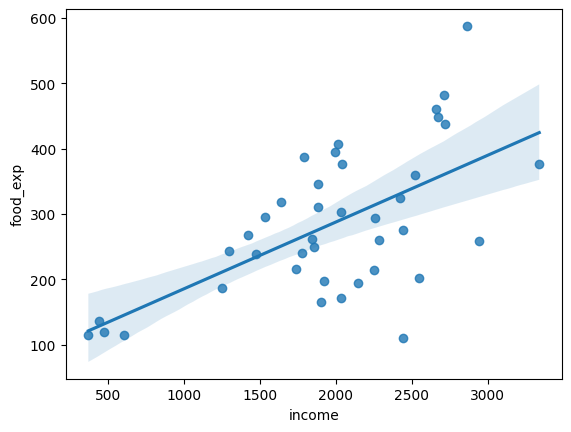

In [18]:
from chapter_07 import Wls
import seaborn as sns

food = pd.read_stata('../2_Data/Data-2e/food.dta')
food.head(),food.describe()

Food_ols = Wls(data=food,
           X_ls=['income'],
           y='food_exp',
           X_aux=['income'])

sns.regplot(x='income', y='food_exp', data=food)
# 有异方差，随收入增加不断扩大

（2） 将food_exp和income进行回归

In [19]:
Food_ols.results_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               food_exp   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     23.79
Date:                Tue, 16 Apr 2024   Prob (F-statistic):           1.95e-05
Time:                        23:22:11   Log-Likelihood:                -235.51
No. Observations:                  40   AIC:                             475.0
Df Residuals:                      38   BIC:                             478.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         83.4160     43.410      1.922      0.062      -4.463     171.295
income         0.1021      0.021      4.877      0.000       0.060       0.144
==============================================================================
Omnibus:                        0.277   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.870   Jarque-Bera (JB):                0.063
Skew:                          -0.097   Prob(JB):                        0.969
Kurtosis:                       2.989   Cond. No.                     6.36e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

（3） BP 检验
LM-pvalue  0.0065 F-pvalue  0.0056  都小于0.05 拒绝原假设，存在异方差

（4）white 检验
LM-pvalue  0.0228 F-pvalue  0.0208  都小于0.05 拒绝原假设，存在异方差

In [21]:
print(Food_ols.bp_test('ols'))

print(Food_ols.white_test('ols'))

(7.3844240587505094, 0.006579113446024876, 8.603500203031192, 0.005659104079711393)
(7.55507758692048, 0.022878931963884342, 4.307883174400312, 0.020801988382372363)


（5）定义食物开支比例 food_share = food_exp / income
上面的过程再来一遍（6）（7）（8）

In [22]:
food_share = food.copy()
food_share['food_share'] = food_share['food_exp']/food_share['income']
food_share.head()

,food_exp,income,food_share
0,115.220001,369.0,0.312249
1,135.979996,439.0,0.309749
2,119.339996,475.0,0.251242
3,114.959999,603.0,0.190647
4,187.050003,1247.0,0.150000


<Axes: xlabel='income', ylabel='food_share'>

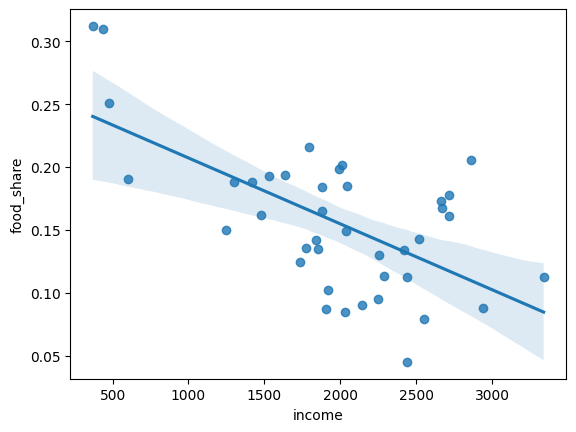

In [24]:
sns.regplot(x='income', y='food_share', data=food_share)
# 好像也有异方差，不敢确定

In [25]:
Food_share_ols = Wls(data=food_share,
           X_ls=['income'],
           y='food_share',
           X_aux=['income'])

Food_share_ols.results_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             food_share   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     24.39
Date:                Tue, 16 Apr 2024   Prob (F-statistic):           1.61e-05
Time:                        23:31:39   Log-Likelihood:                 67.984
No. Observations:                  40   AIC:                            -132.0
Df Residuals:                      38   BIC:                            -128.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2596      0.022     11.799      0.000       0.215       0.304
income      -5.24e-05   1.06e-05     -4.939      0.000   -7.39e-05   -3.09e-05
==============================================================================
Omnibus:                        1.692   Durbin-Watson:                   1.569
Prob(Omnibus):                  0.429   Jarque-Bera (JB):                1.148
Skew:                           0.101   Prob(JB):                        0.563
Kurtosis:                       2.195   Cond. No.                     6.36e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
print(Food_share_ols.bp_test('ols'))
print(Food_share_ols.white_test('ols'))

# 5%的显著性水平下，可以接受原假设，不存在异方差。

(0.08183804684301244, 0.7748218284388266, 0.07790553542229078, 0.781669587073842)
(2.6025904990189908, 0.2721790248734759, 1.2874668292355458, 0.2880436320112215)
